In [12]:
import pandas as pd
import html
import re

# Show all columns without wrapping
pd.set_option('display.max_columns', None)

In [13]:
import netifaces

gateways = netifaces.gateways()
default_gateway = gateways.get('default', {}).get(netifaces.AF_INET)
print(gateways)
if default_gateway:
    router_ip = default_gateway[0]
    print(f"The router IP is likely: {router_ip}")
else:
    print("Could not find the default gateway address.")


{'default': {2: ('192.168.100.1', 'enp39s0'), 10: ('fe80::fe2b:b2ff:fee6:cfa0', 'enp39s0')}, 2: [('192.168.100.1', 'enp39s0', True), ('192.168.100.1', 'wlp41s0', False)], 10: [('fe80::fe2b:b2ff:fee6:cfa0', 'enp39s0', True), ('fe80::fe2b:b2ff:fee6:cfa0', 'wlp41s0', False)]}
The router IP is likely: 192.168.100.1


In [14]:
import subprocess

# Suppose your router IP is 192.168.1.1
router_ip = "192.168.100.1"

result = subprocess.run(["ping", "-c", "1", router_ip], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
if result.returncode == 0:
    print(f"Successfully reached {router_ip}")
else:
    print(f"Could not reach {router_ip}")


Successfully reached 192.168.100.1


In [15]:
import socket

router_ip = "192.168.100.1"
port = 80  # Common for router web admin interface, though some may use 443 or another port

try:
    s = socket.create_connection((router_ip, port), timeout=2)
    print(f"Connected to {router_ip}:{port}")
    s.close()
except (socket.timeout, socket.error) as e:
    print(f"Could not connect to {router_ip}:{port} - {e}")


Connected to 192.168.100.1:80


## Login to the router web interface

In [20]:
import requests
import random
from Crypto.PublicKey import RSA
from Crypto.Cipher import PKCS1_v1_5
from base64 import b64encode
import os
import json

# Load secrets
secrets_path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "secrets", "secrets.json")

try:
    with open(secrets_path, "r") as secrets_file:
        secrets = json.load(secrets_file)
except FileNotFoundError:
    raise FileNotFoundError(f"Secrets file not found at {secrets_path}")

router_ip = secrets["router_ip"]
username = secrets["username"]
plaintext_password = secrets["password"]
modulus_hex = secrets["modulus_hex"]

router_ip = "192.168.100.1"
username = "admin"
plaintext_password = "v2jm5tr6"  # Replace with your actual plaintext password

session = requests.Session()

# GET to establish cookies
resp = session.get(f"http://{router_ip}/logout.cgi", verify=False)

# Generate a sessionId
session_id = random.randint(1, 799999999)

# RSA Encryption of password
modulus_int = int(modulus_hex, 16)
exponent_int = int("10001", 16)  # 65537 in decimal

rsa_key = RSA.construct((modulus_int, exponent_int))
cipher = PKCS1_v1_5.new(rsa_key)
encrypted_pass = cipher.encrypt(plaintext_password.encode('utf-8'))
submitext = b64encode(encrypted_pass).decode('utf-8')

payload = {
    "sessionKey": "0",
    "sessionId": str(session_id),
    "inputUserName": username,
    "inputPassword": submitext,
    "nothankyou": "1"
}

headers = {
    "Host": router_ip,
    "Origin": f"http://{router_ip}",
    "Referer": f"http://{router_ip}/logout.cgi",
    "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/131.0.0.0 Safari/537.36",
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,"
              "image/avif,image/webp,image/apng,*/*;q=0.8,"
              "application/signed-exchange;v=b3;q=0.7",
    "Accept-Encoding": "gzip, deflate",
    "Accept-Language": "en-US,en;q=0.9",
    "Connection": "keep-alive",
    "Content-Type": "application/x-www-form-urlencoded",
    "Upgrade-Insecure-Requests": "1",
    "Cache-Control": "max-age=0"
}

login_resp = session.post(f"http://{router_ip}/login.cgi", data=payload, headers=headers, verify=False)

if "Logout" in login_resp.text or login_resp.status_code == 200:
    print("Login successful!")
    print(login_resp.status_code)
    print("Login response text: \n",login_resp.text)
else:
    print("Login might have failed. Check the response:")
    print(login_resp.text)


Login successful!
200
Login response text: 
 <html>
<head>
<script language="Javascript">
function do_load(){
    window.top.location.href="index.html";
}

</script>
</head>

<body onload="do_load()">

</body>
</html>



In [25]:
import pandas as pd
import requests

def extract_table_data(session, table_url, marker_start, marker_end, entry_splitter, parse_logic):

    response = session.get(table_url, verify=False)
    if response.status_code == 200:
        # Extract the HTML content
        page_content = response.text
        
        if re.search(r'id="login_form"', page_content):
            # loged out
            print("You are no longer logged in")
            return pd.DataFrame()

        if page_content.find(marker_start) == -1:
            print("could no find marker_start")
            return pd.DataFrame()
        
        # Locate the JavaScript variable 'init_value'
        start_idx = page_content.find(marker_start) + len(marker_start)
        end_idx = page_content.find(marker_end, start_idx)

        if start_idx > len(marker_start) and end_idx > start_idx:
            init_value = page_content[start_idx:end_idx]
            
            # Parse the table entries using the provided parsing logic
            table_entries = []
            for entry in init_value.split(entry_splitter):
                if entry.strip():  # Ignore empty entries
                    parsed_entry = parse_logic(entry)
                    if parsed_entry:  # Only add valid entries
                        table_entries.append(parsed_entry)
            
            # Return as a DataFrame
            return pd.DataFrame(table_entries)
        else:
            print(f"Failed to extract table data from the page. find(marker_start): {page_content.find(marker_start)}, marker_start: {marker_start}, marker_end: {marker_end}, start_idx: {start_idx}, end_idx: {end_idx}")
            print(page_content)
    else:
        print(f"Failed to fetch the table page. Status code: {response.status_code}")
    return pd.DataFrame()  # Return an empty DataFrame if parsing fails

Parse Logic for all tables

In [26]:
# Define parse logic for ARP table
def parse_arp_entry(entry):
    parts = entry.split("/")
    if len(parts) == 6:
        return {
            "IP": parts[0],
            "HW_TYPE": parts[1],
            "FLAGS": parts[2],
            "HW_ADDR": parts[3],
            "MASK": parts[4],
            "DEVICE": parts[5]
        }
    return None


# Define parse logic for NAT table
def parse_nat_entry(entry):
    protocol, timeout, src_ip, src_port, dst_ip, dst_port = [None] * 6
    segments = entry.split()

    # First two elements are protocol and timeout
    if len(segments) >= 3:
        protocol = segments[0]
        timeout = segments[2]

    # Parse the first src and dst details
    for segment in segments:
        if "src=" in segment and not src_ip:
            src_ip = segment.split("src=")[-1]
        elif "dst=" in segment and not dst_ip:
            dst_ip = segment.split("dst=")[-1]
        elif "sport=" in segment and not src_port:
            src_port = segment.split("sport=")[-1]
        elif "dport=" in segment and not dst_port:
            dst_port = segment.split("dport=")[-1]

    if all([protocol, timeout, src_ip, src_port, dst_ip, dst_port]):
        return {
            "Protocol": protocol,
            "Timeout": timeout,
            "Source IP": src_ip,
            "Source Port": src_port,
            "Destination IP": dst_ip,
            "Destination Port": dst_port,
        }
    return None

# Define parse logic for dev_list_table
def parse_dev_list_entry(entry):
    parts = entry.split("/")
    if len(parts) >= 7:
        return {
            "Hostname": parts[0],
            "MAC Address": html.unescape(parts[2]),
            "IP Address": parts[1],
            "IP Allocation": parts[4],
            "Interface": parts[6],
            "Ethernet/2G/5G": parts[8],
            "Port": parts[3],
            "Connection Speed": parts[5],
            "Lease Time Remaining": parts[7]
        }
    return None

# Define parse logic for ipv6_dev_list_table
def parse_ipv6_dev_list_entry(entry):
    parts = entry.split("/")
    if len(parts) == 4:
        return {
            "Interface": parts[0],
            "MAC Address": html.unescape(parts[1]),
            "IPv6 GUAddress": html.unescape(parts[2]),
            "IPv6 LLAddress": html.unescape(parts[3]),
        }
    return None

def parse_modem_wireless_client_list(entry):
    parts = entry.split("&@")
    if len(parts) == 11:
        return {
            "Host Name": parts[0],
            "MAC": parts[1],
            "RSSI": parts[2],
            "Connection Duration": parts[3].replace(" seconds", ""),
            "Packets Sent": parts[4],
            "Packets Received": parts[5],
            "Packets Lost": parts[6],
            "PHY Rate": parts[7],
            "Frequency Band": parts[8]
        }
    return None

## Understanding the ARP Table

An **ARP (Address Resolution Protocol) table** is a data structure used by devices on a local network to map **IP addresses** to **MAC (Media Access Control) addresses**. The ARP table only shows currently active devices on your network. If a device is turned off or hasn't communicated with the router in a while, its entry will be removed from the ARP table.

### How It Works in Practice

1. **Scenario**: Your computer wants to send data to `192.168.1.50`.

2. **Check ARP Table**:
   - Before sending the packet at the Ethernet layer, the computer checks its ARP table to see if it already knows the MAC address for that IP.
   - If the entry is found, the computer sends the Ethernet frame directly to the corresponding MAC address.

3. **No Entry Found**:
   - If the ARP table doesn’t contain the MAC address for the IP, the computer broadcasts an **ARP request** packet on the local network:  
     *“Who has 192.168.1.50?”*

4. **Response**:
   - The device with the IP address `192.168.1.50` responds with its MAC address.

5. **Update ARP Table**:
   - The computer updates its ARP table with the newly learned IP-to-MAC mapping.

6. **Future Communication**:
   - For subsequent communications with `192.168.1.50`, the computer can now send packets directly to the known MAC address without repeating the ARP query.

This process ensures efficient communication within a local network by caching IP-to-MAC mappings.

In [27]:
arp_url = f"http://{router_ip}/modemstatus_arptable.html"
arp_df = extract_table_data(session, arp_url, "var init_value=\"", "\";", "|", parse_arp_entry)
print("ARP Table DataFrame:")
arp_df

ARP Table DataFrame:


,IP,HW_TYPE,FLAGS,HW_ADDR,MASK,DEVICE
0,192.168.100.9,0x1,0x2,b0:19:21:df:06:a0,*,br0
1,192.168.100.10,0x1,0x2,ac:84:c6:18:80:d3,*,br0
2,192.168.100.11,0x1,0x2,34:60:f9:2c:87:ce,*,br0
3,192.168.100.3,0x1,0x2,90:ca:fa:cb:30:5e,*,br0
4,192.168.100.13,0x1,0x2,f8:0f:f9:64:c0:10,*,br0
5,192.168.100.4,0x1,0x2,cc:8c:bf:76:c8:33,*,br0
6,192.168.100.23,0x1,0x2,5c:80:b6:b4:1b:cb,*,br0
7,192.168.100.14,0x1,0x2,e4:f0:42:29:0d:63,*,br0
8,192.168.100.5,0x1,0x2,64:ff:0a:a1:1d:a5,*,br0
9,64.180.12.1,0x1,0x2,6c:be:e9:a7:f1:55,*,ewan1.1


NAT (Network Address Translation) Table: Tracks active connections between internal (private) IP addresses and external (public) IP addresses. The NAT table acts like a traffic log showing which internal devices are talking to which external servers and managing the mapping between private and public IP addresses.

In [28]:
nat_url = f"http://{router_ip}/modemstatus_nattable.html"
nat_df = extract_table_data(session, nat_url, "var init_value=\"", "\";", "|", parse_nat_entry)
print("NAT Table DataFrame:")
nat_df

NAT Table DataFrame:


,Protocol,Timeout,Source IP,Source Port,Destination IP,Destination Port
0,udp,212,192.168.100.27,36097,34.120.32.134,443
1,tcp,86659,192.168.100.27,48370,45.56.82.212,443
2,tcp,86659,192.168.100.4,40577,54.212.163.173,8886
3,tcp,86659,192.168.100.27,36406,136.143.186.94,443
4,tcp,86659,192.168.100.27,53856,34.120.32.134,443
5,udp,199,192.168.100.13,35423,8.8.8.8,53
6,udp,273,192.168.100.27,36492,34.120.32.134,443
7,udp,31,192.168.100.27,36133,34.120.32.134,443
8,tcp,259,192.168.100.27,42286,52.18.110.239,443
9,tcp,86659,192.168.100.10,63827,3.213.109.146,443


The LAN Status Table provides an overview of currently connected devices on your Local Area Network (LAN) — essentially, all devices connected to your router via Wi-Fi or Ethernet cables.

In [29]:
lan_status_url = f"http://{router_ip}/modemstatus_lanstatus.html"
dev_list_df = extract_table_data(session, lan_status_url, "var brinfo = '", "';", "|", parse_dev_list_entry)
print("\nDevice List Table DataFrame:")
dev_list_df


Device List Table DataFrame:


,Hostname,MAC Address,IP Address,IP Allocation,Interface,Ethernet/2G/5G,Port,Connection Speed,Lease Time Remaining
0,Unknown,64:ff:0a:a1:1d:a5,192.168.100.5,,802.11,is5G,6,6Mbps,70806
1,Google-Home-Mini,e4:f0:42:29:0d:63,192.168.100.14,DHCP,3,Ethernet,1,1,79687
2,Bruce,00:d8:61:c0:a6:2c,192.168.100.27,DHCP,3,Ethernet,1,1,63967
3,HS105,ac:84:c6:b1:6c:18,192.168.100.16,,802.11,is2G,6,72222 kbps,48189
4,iPhone,1e:61:0b:60:f8:81,192.168.100.15,DHCP,3,Ethernet,1,1,73987
5,Nest-Doorbell-Wired,90:ca:fa:cb:30:5e,192.168.100.3,,802.11,is2G,6,24000 kbps,44529
6,HS200,ac:84:c6:18:80:d3,192.168.100.10,DHCP,3,Ethernet,1,1,82986
7,Google-Nest-Mini,f8:0f:f9:64:c0:10,192.168.100.13,DHCP,3,Ethernet,1,1,81126
8,EAP235-Wall-34-60-F9-2C-87-CE,34:60:f9:2c:87:ce,192.168.100.11,DHCP,3,Ethernet,2,1,83286
9,RokuStreamingStick,b0:ee:7b:b0:f5:37,192.168.100.7,,802.11,is5G,6,130Mbps,83766


In [30]:
ipv6_dev_list_df = extract_table_data(session, lan_status_url, "var ipv6hostinfo = '", "';", "|", parse_ipv6_dev_list_entry)
print("\nIPv6 Device List Table DataFrame:")
ipv6_dev_list_df


IPv6 Device List Table DataFrame:


,Interface,MAC Address,IPv6 GUAddress,IPv6 LLAddress
0,Ethernet,00:d8:61:c0:a6:2c,2001:569:7209:9900:8504:c015:e92b:49e6,fe80::10e9:2081:bd08:a166
1,Ethernet,e4:f0:42:29:0d:63,2001:569:7209:9900:99b0:1af5:e370:b03f,fe80::e6f0:42ff:fe29:d63
2,802.11,90:ca:fa:cb:30:5e,2001:569:7209:9900:b453:a71a:1b29:ffa4,fe80::92ca:faff:fecb:305e
3,Ethernet,f8:0f:f9:64:c0:10,2001:569:7209:9900:d027:8fc:7e8f:8c91,fe80::fa0f:f9ff:fe64:c010
4,802.11,64:ff:0a:a1:1d:a5,2001:569:7209:9900:899c:55df:684c:ce02,fe80::e11c:ee4e:3aec:8042


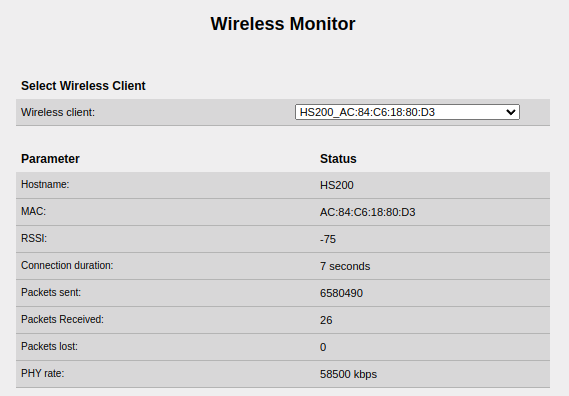

In [31]:
modem_wireless_client_list_url = f"http://{router_ip}/modemstatus_wirelessmonitor.html"
modem_wireless_client_list_df = extract_table_data(session, modem_wireless_client_list_url, "var wirelessclientlistsinfo = '", "';", "@&", parse_modem_wireless_client_list)
print("\nModem wireless client list DataFrame:")
modem_wireless_client_list_df


Modem wireless client list DataFrame:


,Host Name,MAC,RSSI,Connection Duration,Packets Sent,Packets Received,Packets Lost,PHY Rate,Frequency Band
0,Nest-Doorbell-Wired,90:CA:FA:CB:30:5E,-69,85167,1515763,565947,237,24000 kbps,2.4G
1,HS105,AC:84:C6:B1:6C:18,-31,253888,1435142,16320,91,72222 kbps,2.4G
2,RokuStreamingStick,b0:ee:7b:b0:f5:37,-69,89052,1178860,150428,0,130Mbps,5G
3,Unknown,64:ff:0a:a1:1d:a5,-77,58805,502505,336348,0,234Mbps,5G


In [ ]:
find mac vendor based on downloaded mac vendors csv file

In [136]:
import pandas as pd
import os

def add_mac_vendor_to_arp(arp_df):
    """
    Enhance the ARP DataFrame by adding a 'MAC Vendor' column based on MAC prefixes.

    Args:
        arp_df (pd.DataFrame): The ARP table DataFrame.
        project_root (str): Path to the project root where 'data/mac-vendors-export.csv' is located.

    Returns:
        pd.DataFrame: The ARP table DataFrame with the 'MAC Vendor' column added.
    """
    # Path to the MAC vendor database CSV file
    csv_file_path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "data", "mac-vendors-export.csv")
    
    # Load the MAC vendor database
    try:
        mac_vendor_df = pd.read_csv(csv_file_path)
    except FileNotFoundError:
        raise FileNotFoundError(f"MAC vendor database not found at {csv_file_path}. Ensure the file exists.")

    # Ensure the MAC Prefix and Vendor Name columns exist
    required_columns = {"Mac Prefix", "Vendor Name"}
    if not required_columns.issubset(mac_vendor_df.columns):
        raise ValueError(f"The CSV file must contain columns: {required_columns}")

    # Extract the first 8 characters of the MAC addresses for matching
    arp_df["MAC Prefix"] = arp_df["HW_ADDR"].str[:8].str.upper()

    # Merge the ARP table with the MAC vendor database
    arp_df = arp_df.merge(mac_vendor_df, how="left", left_on="MAC Prefix", right_on="Mac Prefix")

    # Rename 'Vendor Name' to 'MAC Vendor' for clarity and drop 'MAC Prefix'
    arp_df.rename(columns={"Vendor Name": "MAC Vendor"}, inplace=True)
    arp_df.drop(columns=["Mac Prefix"], inplace=True)

    return arp_df


In [137]:
add_mac_vendor_to_arp(arp_df)

,IP,HW_TYPE,FLAGS,HW_ADDR,MASK,DEVICE,MAC Prefix,MAC Vendor,Private,Block Type,Last Update
0,192.168.100.5,0x1,0x2,90:ca:fa:cb:30:5e,*,br0,90:CA:FA,"Google, Inc.",False,MA-L,2022/05/17
1,192.168.100.18,0x1,0x2,5c:80:b6:b4:1b:cb,*,br0,5C:80:B6,Intel Corporate,False,MA-L,2019/09/11
2,192.168.100.7,0x1,0x2,34:60:f9:de:b9:32,*,br0,34:60:F9,TP-Link Corporation Limited,False,MA-L,2021/11/02
3,192.168.100.20,0x1,0x2,b0:19:21:df:06:a0,*,br0,B0:19:21,TP-LINK CORPORATION PTE. LTD.,False,MA-L,2024/05/20
4,192.168.100.8,0x1,0x2,f8:0f:f9:64:c0:10,*,br0,F8:0F:F9,"Google, Inc.",False,MA-L,2019/10/17
5,192.168.100.9,0x1,0x2,34:60:f9:2c:87:ce,*,br0,34:60:F9,TP-Link Corporation Limited,False,MA-L,2021/11/02
6,192.168.100.22,0x1,0x2,b0:ee:7b:b0:f5:37,*,br0,B0:EE:7B,"Roku, Inc",False,MA-L,2020/10/15
7,192.168.100.10,0x1,0x2,1e:61:0b:60:f8:81,*,br0,1E:61:0B,NaN,NaN,NaN,NaN
8,192.168.100.23,0x1,0x2,cc:8c:bf:76:c8:33,*,br0,CC:8C:BF,Tuya Smart Inc.,False,MA-L,2021/11/18
9,192.168.100.11,0x1,0x2,ac:84:c6:b1:6c:18,*,br0,AC:84:C6,"TP-LINK TECHNOLOGIES CO.,LTD.",False,MA-L,2017/07/23


To Do: add wireless client lists for 3 wireless access points: main modem and 2 access points. (web scraping)
most interesting data: signal strength!

Load data into bigquery dataset

In [139]:
from google.cloud import bigquery
import pandas as pd

# Set up the credentials file
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "secrets", "bigquery-service-acount-key.json")

# Initialize a BigQuery client
client = bigquery.Client()

# Define your dataset and table
project_id = "home-network-dashboard"
dataset_id = "main_dataset"
table_id = "arp"

# your data is in a dataframe: df

# Define the full table name
table_ref = f"{project_id}.{dataset_id}.{table_id}"

# Upload data to BigQuery
job = client.load_table_from_dataframe(arp_df, table_ref)

# Wait for the job to complete
job.result()

print(f"Uploaded {len(df)} rows to {table_ref}.")


Uploaded 20 rows to home-network-dashboard.main_dataset.arp.


logint to access points

Get Client list for access points

Dashboard: what I would like to see in the final dashboard
for each device a time line that shows to what access point its connected and strengthe of the signal over time
to show new connected devices
